The following code is adapted from https://github.com/ppoffice/ant-colony-tsp, with additional explanation by me.

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change Directory Here
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
#Load Data
import numpy as np
citi_coord = np.load('cities.npy', allow_pickle = True)

In [ ]:
citi_coord

array([[0.42063307, 0.36365371],
       [0.42055583, 0.71203725],
       [0.77196185, 0.52303056],
       ...,
       [0.81118992, 0.84354499],
       [0.78685968, 0.50938438],
       [0.83058875, 0.35190042]])

In [ ]:
#Create a list of cities [0-999], and a list of their coordinates
cities = []
points = []
for i in range(len(citi_coord)):
  cities.append(i)
  points.append(citi_coord[i])

In [ ]:
points

[array([0.42063307, 0.36365371]),
 array([0.42055583, 0.71203725]),
 array([0.77196185, 0.52303056]),
 array([0.12748398, 0.00574547]),
 array([0.95047896, 0.99772089]),
 array([0.97783568, 0.14815507]),
 array([0.33908955, 0.788318  ]),
 array([0.50416545, 0.70909759]),
 array([0.30141812, 0.3569132 ]),
 array([0.62201788, 0.99368885]),
 array([0.94061613, 0.30459642]),
 array([0.26160545, 0.46592118]),
 array([0.07032412, 0.05094768]),
 array([0.79584223, 0.47021897]),
 array([0.07992512, 0.2173173 ]),
 array([0.55716596, 0.77384791]),
 array([0.96699917, 0.42778625]),
 array([0.49208432, 0.43531561]),
 array([0.57206697, 0.09126209]),
 array([0.2492654 , 0.64519184]),
 array([0.51008768, 0.30786566]),
 array([0.28237273, 0.5261765 ]),
 array([0.82899574, 0.44129691]),
 array([0.92842193, 0.80415815]),
 array([0.599894  , 0.45286573]),
 array([0.6358064 , 0.89435069]),
 array([0.34320495, 0.18072625]),
 array([0.9042387 , 0.66710409]),
 array([0.28443775, 0.10589526]),
 array([0.8130

In [ ]:
#Obtain Euclidean Distance between 2 coordinates
def distance(coord1,coord2):
  return np.sqrt(np.sum((coord1-coord2)**2))

In [ ]:
#Create a cost matrix which denotes the distance between city i and city j in its ij-th entry (symmetric)
from tqdm import tqdm
cost_matrix = []
#Rank is the number of cities (1000)
rank = len(cities)
for i in tqdm(range(rank)):
  row = []
  for j in range(rank):
    row.append(distance(points[i], points[j]))
  cost_matrix.append(row)

100%|██████████| 1000/1000 [00:12<00:00, 83.05it/s]


In [ ]:
import random
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        # noinspection PyUnusedLocal
        #ij-th value denotes the pheromone level on path from city i to city j
        #Initial pheremone levels are constant for all paths
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]


class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                #Multiplying by rho (<1) simulates the pheromone evaporating (decreasing in intensity) with time
                graph.pheromone[i][j] *= self.rho
                #Iterate through all the ants and add the pheromone released on the path they took
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        for gen in tqdm(range(self.generations)):
            # noinspection PyUnusedLocal
            #At every generation, initialize ant_count number of ants at random cities
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                #Compute full path for ant
                for i in range(graph.rank - 1):
                    ant._select_next()
                #Compute total cost by closing the loop
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                #Updates current best path and the total distance
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone released by ant
                ant._update_pheromone_delta()
            #Update pheremone levels for all paths
            self._update_pheromone(graph, ants)
            print(best_cost)
            # print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        return best_solution, best_cost


class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list to keep track of the path they took
        self.pheromone_delta = []  # the local increase of pheromone by the ant
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection (no repeated cities)
        #The heuristic is influenced by the distance from the ant's current location (i.e. the closer the city, the higher probability of selecting the city)
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            #normalization constant
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                                                                                            i] ** self.colony.beta
        # noinspection PyUnusedLocal
        probabilities = [0 for i in range(self.graph.rank)]  # initialize probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                #Probabilities of moving to a new city / choosing a path is influenced by heuristic (distance) and pheremone levels
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        #Randomly selectly the next city based on probability distribution given
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        #Updating cost and current location
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        #Initialize pheremone released by ant, ij-th entry is the pheromone released by the ant from city i to city j
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        #Iterate through the path taken by the ant and update the pheremone_delta table
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            #Pheromone released by ant is the same for all ants
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            #Pheromone released by ant is inversely proportional to the length of path from city i to city j
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            #Pheromone released by ant is inversely proportional to the total length of the paths taken by the ant (Shorter TSP Solution -> More Pheromone)
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [ ]:
aco = ACO(10, 50, 1.0, 10.0, 0.5, 10, 0)
graph = Graph(cost_matrix, rank)
path, cost = aco.solve(graph)

  2%|▏         | 1/50 [01:09<57:06, 69.92s/it]

30.30993182739819


  4%|▍         | 2/50 [02:18<55:30, 69.38s/it]

29.326499151286427


  6%|▌         | 3/50 [03:29<54:46, 69.93s/it]

29.326499151286427


  8%|▊         | 4/50 [04:39<53:45, 70.11s/it]

29.326499151286427


 10%|█         | 5/50 [05:57<54:38, 72.85s/it]

29.326499151286427


 12%|█▏        | 6/50 [07:21<56:16, 76.74s/it]

29.266151581147312


 14%|█▍        | 7/50 [08:38<54:58, 76.71s/it]

29.266151581147312


 16%|█▌        | 8/50 [09:59<54:42, 78.15s/it]

29.266151581147312


 18%|█▊        | 9/50 [11:17<53:19, 78.04s/it]

29.266151581147312


 20%|██        | 10/50 [12:35<52:02, 78.07s/it]

29.266151581147312


 22%|██▏       | 11/50 [13:57<51:35, 79.36s/it]

29.266151581147312


 24%|██▍       | 12/50 [15:14<49:44, 78.54s/it]

29.266151581147312


 26%|██▌       | 13/50 [16:40<49:45, 80.69s/it]

29.266151581147312


 28%|██▊       | 14/50 [17:59<48:03, 80.11s/it]

29.266151581147312


 30%|███       | 15/50 [19:23<47:27, 81.36s/it]

29.266151581147312


 32%|███▏      | 16/50 [20:49<46:57, 82.85s/it]

29.091628554486824


 34%|███▍      | 17/50 [22:04<44:19, 80.58s/it]

29.091628554486824


 36%|███▌      | 18/50 [23:21<42:24, 79.52s/it]

29.091628554486824


 38%|███▊      | 19/50 [24:46<41:55, 81.14s/it]

29.091628554486824


 40%|████      | 20/50 [26:02<39:40, 79.34s/it]

29.091628554486824


 42%|████▏     | 21/50 [27:12<37:03, 76.68s/it]

29.091628554486824


 44%|████▍     | 22/50 [28:23<34:55, 74.85s/it]

29.091628554486824


 46%|████▌     | 23/50 [29:32<32:52, 73.06s/it]

29.091628554486824


 48%|████▊     | 24/50 [30:41<31:14, 72.10s/it]

29.091628554486824


 50%|█████     | 25/50 [31:52<29:49, 71.58s/it]

29.091628554486824


 52%|█████▏    | 26/50 [33:02<28:28, 71.20s/it]

29.091628554486824


 54%|█████▍    | 27/50 [34:13<27:14, 71.06s/it]

29.091628554486824


 56%|█████▌    | 28/50 [35:23<25:58, 70.82s/it]

28.909505261240287


 58%|█████▊    | 29/50 [36:32<24:32, 70.12s/it]

28.909505261240287


 60%|██████    | 30/50 [37:42<23:22, 70.11s/it]

28.909505261240287


 62%|██████▏   | 31/50 [38:52<22:14, 70.22s/it]

28.909505261240287


 64%|██████▍   | 32/50 [40:03<21:06, 70.36s/it]

28.909505261240287


 66%|██████▌   | 33/50 [41:13<19:56, 70.38s/it]

28.909505261240287


 68%|██████▊   | 34/50 [42:23<18:45, 70.35s/it]

28.909505261240287


 70%|███████   | 35/50 [43:32<17:27, 69.82s/it]

28.12079445186181


 72%|███████▏  | 36/50 [44:42<16:19, 69.94s/it]

28.12079445186181


 74%|███████▍  | 37/50 [45:53<15:10, 70.07s/it]

28.12079445186181


 76%|███████▌  | 38/50 [47:03<14:02, 70.18s/it]

28.12079445186181


 78%|███████▊  | 39/50 [48:14<12:53, 70.28s/it]

28.12079445186181


 80%|████████  | 40/50 [49:24<11:42, 70.25s/it]

28.12079445186181


 82%|████████▏ | 41/50 [50:33<10:28, 69.82s/it]

28.12079445186181


 84%|████████▍ | 42/50 [51:42<09:18, 69.84s/it]

28.12079445186181


 86%|████████▌ | 43/50 [52:53<08:10, 70.01s/it]

28.12079445186181


 88%|████████▊ | 44/50 [54:03<07:00, 70.13s/it]

28.12079445186181


 90%|█████████ | 45/50 [55:14<05:50, 70.18s/it]

28.12079445186181


 92%|█████████▏| 46/50 [56:24<04:41, 70.33s/it]

28.12079445186181


 94%|█████████▍| 47/50 [57:33<03:29, 69.80s/it]

28.12079445186181


 96%|█████████▌| 48/50 [58:43<02:19, 69.88s/it]

28.12079445186181


 98%|█████████▊| 49/50 [59:53<01:09, 70.00s/it]

28.12079445186181


100%|██████████| 50/50 [1:01:03<00:00, 73.28s/it]

28.12079445186181


In [ ]:
cost

28.12079445186181

In [ ]:
print(path)

[672, 845, 233, 368, 960, 979, 31, 194, 84, 130, 150, 627, 155, 63, 729, 625, 892, 747, 926, 451, 682, 502, 668, 198, 257, 983, 709, 395, 664, 990, 218, 688, 571, 125, 965, 204, 402, 907, 195, 760, 165, 969, 600, 693, 559, 286, 908, 734, 380, 914, 513, 30, 939, 782, 241, 510, 174, 985, 864, 305, 588, 993, 248, 342, 463, 265, 456, 237, 683, 499, 56, 107, 585, 778, 551, 924, 835, 501, 61, 772, 685, 411, 594, 742, 677, 397, 898, 219, 586, 543, 511, 851, 505, 365, 361, 753, 307, 932, 364, 258, 995, 99, 481, 837, 232, 186, 226, 977, 667, 739, 610, 632, 197, 996, 849, 781, 786, 371, 572, 780, 281, 166, 798, 489, 352, 517, 326, 271, 493, 312, 724, 158, 712, 453, 530, 792, 277, 486, 247, 576, 546, 953, 687, 420, 975, 954, 764, 51, 601, 389, 406, 338, 394, 971, 222, 422, 207, 296, 982, 662, 744, 87, 788, 473, 705, 565, 994, 891, 455, 123, 913, 621, 384, 757, 708, 386, 3, 536, 372, 961, 740, 102, 245, 912, 789, 638, 597, 794, 802, 942, 480, 151, 697, 843, 403, 357, 958, 726, 76, 548, 880, 470, 7

In [ ]:
points[0][0]

0.4206330700704898

In [ ]:
import pylab as plt
#getting x and y coordinates into separate lists
x = list(map(lambda x: x[0],points))
y = list(map(lambda x: x[1],points))

In [ ]:
path
#Getting the coordinates in the order of the path
x_path = [x[i] for i in path]
y_path = [y[i] for i in path]

28.12079445186181


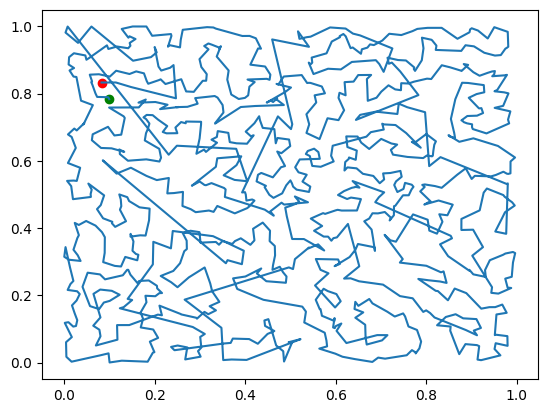

In [ ]:
plt.plot(x_path,y_path)
#plotting out the TSP path
plt.scatter(x_path[0],y_path[0], color = "green")
plt.scatter(x_path[-1],y_path[-1], color = "red")
print(cost)

Observing the path, it is obvious that there are still many occurences of the path intersecting with itself, which is highly inefficient. Therefore we further improve the solution using the 2-opt algo

In [ ]:
#Function for computing cost
def route_length(route):
  return sum(cost_matrix[route[i]][route[i+1]] for i in range(len(route)-1)) + cost_matrix[route[0]][route[-1]]

In [ ]:
#2-opt algorithm from 2-opt notebook
def two_opt(route):
  n = len(route)
  improved = True
  best_distance = route_length(route)
  start = 1
  while improved:
    improved = False
    best_distance = route_length(route)
    for i in tqdm(range(start,n-2)):
      if improved:
        break
      for j in range(i+1, n-1):
        new_route = route[:i] + route[i:j+1][::-1] + route[j+1:]
        new_distance = route_length(new_route)
        if new_distance < best_distance:
          route = new_route
          best_distance = new_distance
          print("best: ", best_distance)
          improved = True
          start = max(i - 5, start) #does not start the next loop from 0, so the code can run faster
        if improved:
          break
  return route

In [ ]:
route_length(path)

28.12079445186181

In [ ]:
#Compute new path after 2 opt optimisation
new_path = two_opt(path)

  0%|          | 1/997 [00:00<04:39,  3.56it/s]


best:  28.112614636493664


  0%|          | 1/997 [00:00<04:23,  3.77it/s]


best:  28.10958798805596


  0%|          | 1/997 [00:00<00:01, 550.58it/s]


best:  28.0792460950021


  0%|          | 1/997 [00:00<02:15,  7.35it/s]


best:  28.049525107633936


  0%|          | 2/997 [00:00<03:20,  4.96it/s]


best:  28.040816333290334


  0%|          | 2/997 [00:00<03:20,  4.97it/s]


best:  28.025595559488995


  0%|          | 2/997 [00:00<03:19,  4.99it/s]


best:  28.00749129183941


  1%|          | 6/997 [00:01<03:40,  4.50it/s]


best:  27.986890869917378


  1%|          | 8/997 [00:01<03:48,  4.32it/s]


best:  27.975820219829128


  2%|▏         | 20/995 [00:07<05:48,  2.80it/s]


best:  27.926962567396483


  1%|          | 8/981 [00:01<03:53,  4.16it/s]


best:  27.924524110372648


  1%|          | 6/979 [00:01<03:45,  4.31it/s]


best:  27.91811545532588


  1%|          | 6/979 [00:01<03:49,  4.24it/s]


best:  27.87738423812218


  1%|          | 10/979 [00:02<03:49,  4.22it/s]


best:  27.864159672313175


  1%|          | 7/975 [00:01<03:36,  4.48it/s]


best:  27.84686695331069


  1%|▏         | 14/974 [00:05<06:13,  2.57it/s]


best:  27.845057800494377


  2%|▏         | 18/966 [00:04<03:50,  4.12it/s]


best:  27.84453462393022


  1%|          | 7/954 [00:01<03:27,  4.57it/s]


best:  27.84155301508797


  1%|          | 5/953 [00:01<03:12,  4.93it/s]


best:  27.841390467996842


  2%|▏         | 15/953 [00:04<04:20,  3.61it/s]


best:  27.821874128761433


  1%|          | 6/944 [00:02<06:27,  2.42it/s]


best:  27.80942086385775


  1%|          | 9/944 [00:02<04:02,  3.85it/s]


best:  27.807134608345446


  5%|▍         | 46/941 [00:13<04:17,  3.47it/s]


best:  27.799809523125692


  1%|          | 10/901 [00:02<03:11,  4.66it/s]


best:  27.799342374896508


  1%|          | 8/897 [00:01<03:08,  4.71it/s]


best:  27.79847862115479


  5%|▌         | 49/895 [00:13<03:48,  3.71it/s]


best:  27.78203166584201


  2%|▏         | 17/852 [00:03<02:58,  4.68it/s]


best:  27.78164779208006


  1%|          | 6/841 [00:01<02:39,  5.23it/s]


best:  27.777967457814515


  1%|          | 8/841 [00:01<02:43,  5.09it/s]


best:  27.777369160130913


  1%|          | 6/839 [00:01<04:15,  3.26it/s]


best:  27.77678439982876


  1%|          | 6/839 [00:02<04:56,  2.81it/s]


best:  27.771067531433747


  1%|          | 8/839 [00:01<03:23,  4.07it/s]


best:  27.76505461952848


  2%|▏         | 20/837 [00:04<02:49,  4.83it/s]


best:  27.72453252010712


  2%|▏         | 14/823 [00:02<02:44,  4.93it/s]


best:  27.722398174258483


  1%|▏         | 11/815 [00:02<02:59,  4.48it/s]


best:  27.703001737186103


  1%|          | 9/810 [00:03<04:58,  2.69it/s]


best:  27.699353029834175


  1%|▏         | 12/807 [00:02<02:53,  4.58it/s]


best:  27.648382018702957


  0%|          | 3/801 [00:00<01:54,  6.96it/s]


best:  27.6364194363293


  0%|          | 3/801 [00:00<01:59,  6.67it/s]


best:  27.632102269707868


  3%|▎         | 26/801 [00:05<02:36,  4.97it/s]


best:  27.631561818191845


  1%|          | 6/781 [00:01<02:17,  5.64it/s]


best:  27.627292551607493


  1%|          | 7/781 [00:01<03:19,  3.89it/s]


best:  27.622366559962085


  1%|          | 7/780 [00:02<04:23,  2.93it/s]


best:  27.616485595724978


  1%|          | 9/779 [00:02<02:56,  4.37it/s]


best:  27.615353676593156


  3%|▎         | 21/776 [00:04<02:28,  5.09it/s]


best:  27.582554018356536


  3%|▎         | 21/761 [00:04<02:26,  5.04it/s]


best:  27.545402534249067


  1%|          | 6/746 [00:01<03:03,  4.03it/s]


best:  27.52609682619421


  1%|          | 9/746 [00:03<04:26,  2.77it/s]


best:  27.509544449181863


  1%|          | 9/743 [00:01<02:22,  5.16it/s]


best:  27.493921891554326


  0%|          | 2/740 [00:00<01:12, 10.24it/s]


best:  27.478945619281742


  2%|▏         | 12/740 [00:02<02:09,  5.64it/s]


best:  27.476334927047855


  1%|          | 9/734 [00:01<02:13,  5.42it/s]


best:  27.4438119815194


  2%|▏         | 15/731 [00:02<02:09,  5.52it/s]


best:  27.43131158524032


  2%|▏         | 15/722 [00:03<02:55,  4.03it/s]


best:  27.426179847903317


  1%|          | 6/713 [00:01<03:40,  3.20it/s]


best:  27.424441184025053


  1%|          | 6/713 [00:01<02:14,  5.24it/s]


best:  27.415389257869922


  1%|          | 7/713 [00:01<01:57,  6.03it/s]


best:  27.41398089503058


  1%|          | 6/712 [00:00<01:53,  6.20it/s]


best:  27.41290786928941


  1%|          | 7/712 [00:01<01:56,  6.05it/s]


best:  27.407514312434085


  1%|▏         | 10/711 [00:01<02:00,  5.80it/s]


best:  27.40084603311261


  1%|          | 8/707 [00:01<01:54,  6.10it/s]


best:  27.376444177316724


  1%|          | 4/705 [00:00<01:40,  6.98it/s]


best:  27.355599230852913


  1%|          | 6/705 [00:01<01:58,  5.90it/s]


best:  27.340539564121823


  1%|          | 6/705 [00:01<01:57,  5.94it/s]


best:  27.32578778924636


  1%|          | 6/705 [00:01<03:29,  3.34it/s]


best:  27.312687425947107


  2%|▏         | 12/705 [00:03<03:21,  3.43it/s]


best:  27.287295213164324


  2%|▏         | 13/699 [00:02<02:02,  5.61it/s]


best:  27.276157574558066


  0%|          | 1/692 [00:00<00:50, 13.72it/s]


best:  27.275865110262583


  3%|▎         | 21/692 [00:03<01:56,  5.74it/s]


best:  27.272374234916317


  4%|▍         | 26/677 [00:05<02:22,  4.57it/s]


best:  27.27063959748769


  1%|          | 8/657 [00:02<02:52,  3.76it/s]


best:  27.240766628610583


  1%|          | 8/655 [00:01<01:38,  6.55it/s]


best:  27.20857515019971


  1%|          | 7/653 [00:01<01:37,  6.64it/s]


best:  27.186391667888184


  1%|          | 8/652 [00:01<01:38,  6.54it/s]


best:  27.185531018666882


  1%|          | 6/650 [00:00<01:37,  6.59it/s]


best:  27.16951755620985


  1%|          | 6/650 [00:00<01:39,  6.47it/s]


best:  27.116274076870436


  2%|▏         | 12/650 [00:01<01:41,  6.27it/s]


best:  27.113590004287556


  2%|▏         | 15/644 [00:02<01:42,  6.13it/s]


best:  27.09180277618739


  1%|          | 6/635 [00:01<02:52,  3.64it/s]


best:  27.076868856461328


  3%|▎         | 21/635 [00:04<02:17,  4.47it/s]


best:  27.062445119353224


  1%|          | 4/620 [00:00<01:25,  7.20it/s]


best:  27.058439381365705


  2%|▏         | 15/620 [00:02<01:34,  6.41it/s]


best:  27.052695685376417


  1%|          | 7/611 [00:00<01:24,  7.17it/s]


best:  27.04458937604012


  1%|▏         | 9/610 [00:01<01:29,  6.70it/s]


best:  27.024109641304154


  1%|          | 7/607 [00:00<01:24,  7.10it/s]


best:  27.015578125951922


  3%|▎         | 19/606 [00:03<02:03,  4.76it/s]


best:  27.014955149855265


  2%|▏         | 10/593 [00:02<02:25,  4.00it/s]


best:  27.011008860385363


  1%|          | 6/589 [00:00<01:17,  7.54it/s]


best:  26.951649290271614


  2%|▏         | 11/589 [00:01<01:23,  6.89it/s]


best:  26.951462479204952


  1%|▏         | 8/584 [00:01<01:19,  7.23it/s]


best:  26.944920488675404


  1%|          | 4/582 [00:00<01:10,  8.17it/s]


best:  26.944073689556998


  3%|▎         | 15/582 [00:02<01:22,  6.85it/s]


best:  26.93476954558724


  5%|▌         | 29/573 [00:05<01:35,  5.70it/s]


best:  26.932053424310592


  1%|          | 6/550 [00:01<02:07,  4.25it/s]


best:  26.918087925357124


  0%|          | 1/550 [00:00<00:03, 139.28it/s]


best:  26.914500197441644


  1%|▏         | 7/550 [00:01<01:56,  4.65it/s]


best:  26.89471955406953


  1%|          | 5/549 [00:00<01:05,  8.36it/s]


best:  26.783119209498974


  1%|          | 6/549 [00:00<01:07,  8.06it/s]


best:  26.779982146525956


  1%|▏         | 8/549 [00:01<01:15,  7.21it/s]


best:  26.771675378267634


  2%|▏         | 12/547 [00:01<01:16,  6.99it/s]


best:  26.747019159082985


  1%|▏         | 7/541 [00:00<01:12,  7.40it/s]


best:  26.729989853448114


  3%|▎         | 18/540 [00:02<01:14,  7.05it/s]


best:  26.71350900759109


  2%|▏         | 9/528 [00:01<01:07,  7.71it/s]


best:  26.709408546171698


  1%|          | 6/525 [00:00<01:03,  8.18it/s]


best:  26.708097807775825


  2%|▏         | 8/525 [00:01<01:59,  4.33it/s]


best:  26.707799641147783


  2%|▏         | 11/523 [00:02<02:04,  4.10it/s]


best:  26.700780810918953


  1%|          | 6/518 [00:00<01:01,  8.30it/s]


best:  26.681158325765924


  1%|          | 6/518 [00:00<01:00,  8.51it/s]


best:  26.65586941973368


  1%|▏         | 7/518 [00:00<01:03,  8.11it/s]


best:  26.650549796520767


  3%|▎         | 14/517 [00:01<01:05,  7.70it/s]


best:  26.647909552430743


  1%|          | 6/509 [00:00<00:58,  8.63it/s]


best:  26.62798295590591


  1%|          | 6/509 [00:00<00:57,  8.80it/s]


best:  26.626277373992504


  2%|▏         | 9/509 [00:01<01:01,  8.19it/s]


best:  26.61589770166915


  1%|          | 6/506 [00:00<00:57,  8.73it/s]


best:  26.615260843718065


  1%|          | 6/506 [00:00<00:56,  8.80it/s]


best:  26.583627047747175


  3%|▎         | 17/506 [00:02<01:10,  6.96it/s]


best:  26.581801108804722


  1%|          | 6/495 [00:01<01:45,  4.64it/s]


best:  26.58009895855547


  1%|▏         | 7/495 [00:01<01:48,  4.48it/s]


best:  26.568695561743144


  2%|▏         | 12/494 [00:01<01:17,  6.20it/s]


best:  26.56026753010057


  1%|▏         | 7/488 [00:00<00:55,  8.73it/s]


best:  26.557360058388458


  3%|▎         | 17/487 [00:02<00:58,  8.10it/s]


best:  26.546985530536173


  2%|▏         | 10/476 [00:01<00:54,  8.49it/s]


best:  26.54604346654993


  3%|▎         | 13/472 [00:01<00:55,  8.29it/s]


best:  26.520908058073093


  1%|▏         | 6/465 [00:00<00:48,  9.38it/s]


best:  26.518471060504314


  1%|▏         | 6/465 [00:00<00:49,  9.26it/s]


best:  26.50474609466723


  2%|▏         | 10/465 [00:01<00:52,  8.71it/s]


best:  26.499453587305464


  2%|▏         | 11/461 [00:01<01:05,  6.85it/s]


best:  26.477180215627097


  1%|▏         | 6/456 [00:01<01:28,  5.10it/s]


best:  26.451669803264448


  6%|▌         | 26/456 [00:04<01:10,  6.09it/s]


best:  26.45007961835908


  7%|▋         | 32/436 [00:03<00:46,  8.78it/s]


best:  26.437414905533213


  2%|▏         | 7/410 [00:00<00:39, 10.12it/s]


best:  26.435644432167006


  8%|▊         | 33/409 [00:03<00:39,  9.56it/s]


best:  26.42982777788318


  4%|▎         | 14/382 [00:02<00:58,  6.28it/s]


best:  26.38335685548368


  4%|▍         | 15/374 [00:02<01:02,  5.73it/s]


best:  26.371995767576035


  2%|▏         | 8/365 [00:00<00:31, 11.39it/s]


best:  26.358345520911715


  2%|▏         | 8/363 [00:00<00:30, 11.46it/s]


best:  26.355177609397845


  3%|▎         | 10/361 [00:00<00:30, 11.69it/s]


best:  26.332844716608005


  4%|▍         | 15/357 [00:01<00:30, 11.27it/s]


best:  26.324496004828195


  5%|▌         | 18/348 [00:01<00:28, 11.60it/s]


best:  26.323419477140003


  9%|▊         | 29/336 [00:02<00:26, 11.73it/s]


best:  26.316240617999494


  7%|▋         | 23/313 [00:01<00:23, 12.59it/s]


best:  26.315245282469913


  2%|▏         | 6/296 [00:00<00:19, 14.56it/s]


best:  26.289524132623836


  2%|▏         | 7/296 [00:00<00:40,  7.17it/s]


best:  26.280733937333853


  2%|▏         | 6/295 [00:00<00:38,  7.46it/s]


best:  26.254843002783733


  2%|▏         | 7/295 [00:00<00:40,  7.18it/s]


best:  26.227663988963545


  3%|▎         | 8/294 [00:01<00:39,  7.30it/s]


best:  26.22410338137829


  1%|▏         | 4/292 [00:00<00:35,  8.12it/s]


best:  26.221813643344152


  2%|▏         | 6/292 [00:00<00:24, 11.74it/s]


best:  26.2155603926879


  1%|          | 2/292 [00:00<00:13, 21.07it/s]


best:  26.214615269985647


  2%|▏         | 5/292 [00:00<00:19, 14.92it/s]


best:  26.2056652921025


  2%|▏         | 6/292 [00:00<00:19, 14.41it/s]


best:  26.189223752532232


  4%|▍         | 11/292 [00:00<00:20, 13.95it/s]


best:  26.162645108970235


  3%|▎         | 8/287 [00:00<00:18, 14.85it/s]


best:  26.161300337128406


  2%|▏         | 6/285 [00:00<00:17, 15.59it/s]


best:  26.160001523049456


  5%|▍         | 14/285 [00:00<00:19, 14.18it/s]


best:  26.157709019629056


  4%|▍         | 11/277 [00:00<00:18, 14.65it/s]


best:  26.123132765121373


  6%|▋         | 17/272 [00:01<00:17, 14.58it/s]


best:  26.108732121162323


  2%|▏         | 6/261 [00:00<00:15, 16.73it/s]


best:  26.066453957256794


  2%|▏         | 6/261 [00:00<00:15, 16.37it/s]


best:  26.055217917435453


  2%|▏         | 6/261 [00:00<00:16, 15.21it/s]


best:  26.040404671799255


  2%|▏         | 6/261 [00:00<00:15, 16.25it/s]


best:  26.007643362753743


 12%|█▏        | 31/261 [00:02<00:15, 15.29it/s]


best:  26.007391393618878


  3%|▎         | 6/236 [00:00<00:12, 18.16it/s]


best:  25.9950116686889


  2%|▏         | 4/236 [00:00<00:11, 19.90it/s]


best:  25.993626399614588


  4%|▍         | 10/236 [00:01<00:25,  8.80it/s]


best:  25.978256699092977


  4%|▍         | 9/232 [00:00<00:23,  9.44it/s]


best:  25.97785561304457


  3%|▎         | 6/229 [00:00<00:22, 10.12it/s]


best:  25.976965450867194


  3%|▎         | 6/229 [00:00<00:22,  9.87it/s]


best:  25.974427201327938


  3%|▎         | 7/229 [00:00<00:22,  9.89it/s]


best:  25.96867378567625


  4%|▍         | 10/228 [00:00<00:19, 11.13it/s]


best:  25.948098278977266


  0%|          | 1/224 [00:00<00:00, 236.09it/s]


best:  25.942216857323306


  1%|          | 2/224 [00:00<00:09, 23.80it/s]


best:  25.924446634984395


  3%|▎         | 6/224 [00:00<00:11, 19.71it/s]


best:  25.921397143224684


  3%|▎         | 7/224 [00:00<00:11, 18.59it/s]


best:  25.917907061576077


  2%|▏         | 5/223 [00:00<00:11, 19.67it/s]


best:  25.91727249372457


  4%|▎         | 8/223 [00:00<00:11, 18.39it/s]


best:  25.91598687394838


  3%|▎         | 7/221 [00:00<00:11, 18.20it/s]


best:  25.91308058457704


  2%|▏         | 5/220 [00:00<00:10, 19.73it/s]


best:  25.89270462302183


  6%|▌         | 13/220 [00:00<00:11, 17.57it/s]


best:  25.879460133010905


  8%|▊         | 17/213 [00:00<00:10, 18.36it/s]


best:  25.878216833041495


  3%|▎         | 6/202 [00:00<00:08, 21.81it/s]


best:  25.867738669928247


  3%|▎         | 7/202 [00:00<00:09, 21.15it/s]


best:  25.855473285051136


 17%|█▋        | 34/201 [00:01<00:08, 20.05it/s]


best:  25.853175951734453


  8%|▊         | 14/173 [00:00<00:06, 23.51it/s]


best:  25.851695178630646


 13%|█▎        | 22/165 [00:00<00:05, 23.93it/s]


best:  25.843795285964735


 18%|█▊        | 27/149 [00:01<00:04, 27.00it/s]


best:  25.841353167886783


 18%|█▊        | 23/128 [00:00<00:03, 32.08it/s]


best:  25.833696889716045


  9%|▉         | 10/111 [00:00<00:03, 33.56it/s]


best:  25.746086852912025


  4%|▎         | 4/107 [00:00<00:04, 23.73it/s]


best:  25.736588875895972


 21%|██▏       | 23/107 [00:01<00:04, 20.09it/s]


best:  25.719633905213367


  7%|▋         | 6/90 [00:00<00:03, 26.36it/s]


best:  25.719236813388584


  7%|▋         | 6/90 [00:00<00:03, 27.01it/s]


best:  25.717785472837058


  8%|▊         | 7/90 [00:00<00:03, 25.19it/s]


best:  25.715035090069048


 10%|█         | 9/89 [00:00<00:03, 24.31it/s]


best:  25.71082167265118


 12%|█▏        | 10/86 [00:00<00:02, 26.25it/s]


best:  25.682398734930132


  7%|▋         | 6/82 [00:00<00:02, 27.48it/s]


best:  25.673050371479462


  7%|▋         | 6/82 [00:00<00:03, 21.46it/s]


best:  25.66966128286899


  9%|▊         | 7/82 [00:00<00:02, 26.63it/s]


best:  25.661698831340434


  9%|▊         | 7/81 [00:00<00:02, 29.29it/s]


best:  25.64360475507646


 26%|██▋       | 21/80 [00:00<00:02, 28.28it/s]


best:  25.64172221888401


  9%|▉         | 6/65 [00:00<00:01, 36.20it/s]


best:  25.632337259154664


 26%|██▌       | 17/65 [00:00<00:00, 53.43it/s]


best:  25.621834210344094


 24%|██▍       | 13/54 [00:00<00:00, 78.73it/s]


best:  25.621469449926792


 36%|███▌      | 17/47 [00:00<00:00, 86.19it/s]


best:  25.61898526209002


 39%|███▉      | 14/36 [00:00<00:00, 99.52it/s]


best:  25.617460644448858


 57%|█████▋    | 16/28 [00:00<00:00, 156.21it/s]


best:  25.559569325762887


100%|██████████| 18/18 [00:00<00:00, 309.01it/s]


In [ ]:
route_length(new_path)

25.559569325762887

In [ ]:
new_path

[672,
 695,
 949,
 159,
 624,
 425,
 663,
 820,
 110,
 915,
 853,
 911,
 569,
 350,
 6,
 956,
 93,
 230,
 893,
 349,
 544,
 809,
 459,
 180,
 439,
 370,
 634,
 921,
 205,
 978,
 393,
 902,
 344,
 796,
 9,
 181,
 777,
 239,
 301,
 803,
 669,
 115,
 776,
 704,
 556,
 457,
 503,
 717,
 424,
 696,
 471,
 812,
 379,
 676,
 400,
 25,
 626,
 741,
 723,
 292,
 494,
 731,
 41,
 604,
 743,
 438,
 483,
 52,
 490,
 508,
 114,
 160,
 589,
 378,
 212,
 732,
 163,
 4,
 57,
 336,
 937,
 987,
 865,
 885,
 563,
 339,
 322,
 710,
 433,
 699,
 595,
 881,
 314,
 623,
 567,
 442,
 611,
 136,
 607,
 48,
 34,
 472,
 799,
 997,
 293,
 414,
 255,
 988,
 256,
 561,
 647,
 391,
 691,
 208,
 886,
 689,
 436,
 75,
 646,
 356,
 482,
 404,
 392,
 514,
 264,
 525,
 840,
 319,
 498,
 55,
 766,
 506,
 79,
 521,
 783,
 348,
 213,
 330,
 224,
 547,
 671,
 903,
 88,
 353,
 23,
 323,
 351,
 537,
 149,
 598,
 615,
 967,
 396,
 869,
 313,
 27,
 217,
 972,
 702,
 440,
 450,
 868,
 253,
 817,
 360,
 210,
 784,
 227,
 16,
 168,


25.559569325762887


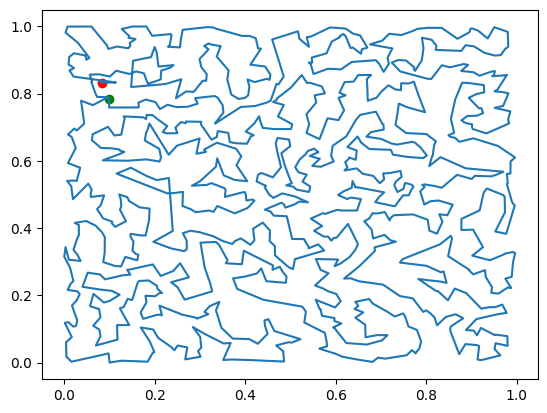

In [ ]:
#Plotting optimised path
x_newpath = [x[i] for i in new_path]
y_newpath = [y[i] for i in new_path]
plt.plot(x_newpath,y_newpath)
plt.scatter(x_newpath[0],y_newpath[0], color = "green")
plt.scatter(x_newpath[-1],y_newpath[-1], color = "red")
print(route_length(new_path))

The number of occurences where the path intersects with itself has greatly reduced, and the total distance has improved from 28.12 to 25.55